In [115]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft, fftfreq

file_path = r'C:\Users\micha\Downloads\train_dataset_1\a000_1\data.hdf5'

Idea: When clustering we are looking to target relevant behaviour. If naive and applied to the whole data set, emergent groups would correspond to behaviour on the choosen time scale. For dt=0.05 this could be swinging the IMU left or right, or changing orientation. But as we are interested in behaviour on the seconds scale, like walking or sitting or talking on the phone, a relevant "time binning" must be applied. 

In [116]:
if '..' not in sys.path:
    sys.path.append('../')
from utils import load_data
data_dict = load_data(file_path, verbose=False)

N = 67_000 #Chopped to fit time bins
time_bin_size = 1000 #5 seconds pr behavior bin
num_bins = int(N/time_bin_size) #Giving 67 time bins

if N == 0:
    ekf_ori = data_dict['pose/ekf_ori']
    tango_ori = data_dict['pose/tango_ori']
    gyro = data_dict['synced/gyro']
    gyro_uncalib = data_dict['synced/gyro_uncalib']
    acc = data_dict['synced/acce']
    linacc = data_dict['synced/linacce']
    mag = data_dict['synced/magnet']
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time']
    rv = data_dict['synced/rv']
    game_rv = data_dict['synced/game_rv']
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]
    
else:
    ekf_ori = data_dict['pose/ekf_ori'][:N]
    tango_ori = data_dict['pose/tango_ori'][:N]
    gyro = data_dict['synced/gyro'][:N]
    gyro_uncalib = data_dict['synced/gyro_uncalib'][:N]
    acc = data_dict['synced/acce'][:N]
    linacc = data_dict['synced/linacce'][:N]
    mag = data_dict['synced/magnet'][:N]
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time'][:N]
    rv = data_dict['synced/rv'][:N]
    game_rv = data_dict['synced/game_rv'][:N]
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]

selected_features = np.concatenate([ekf_ori.T, acc.T]).T #For now I only work with orientation and acceleration

print(ekf_ori.shape,acc.shape)

data_unprocessed = np.zeros((selected_features.shape[1], num_bins, time_bin_size))

#print(selected_features[j*time_bin_size : (j+1)*time_bin_size ].shape, i)

for i in range(selected_features.shape[1]):
    for j in range(num_bins):
        data_unprocessed[i,j,:] = selected_features[j*time_bin_size : (j+1)*time_bin_size, i]

#print(data_unprocessed.shape)

(67000, 4) (67000, 3)


Additionally a guiding hand in extracting the relevent features from the data should be applied. Characteristics of behaviour could be the average, the std and FFT of the orientation and acceration in the time bin.

In [117]:
data_average = np.mean(data_unprocessed, axis=2)
data_std = np.std(data_unprocessed, axis=2)
data_signal = (data_unprocessed - data_average[:,:,None])/data_std[:,:,None]
data_fft = fft(data_signal, axis=2)
print(data_fft.shape)

(7, 67, 1000)


c:\Users\micha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'FFT Acceleration')

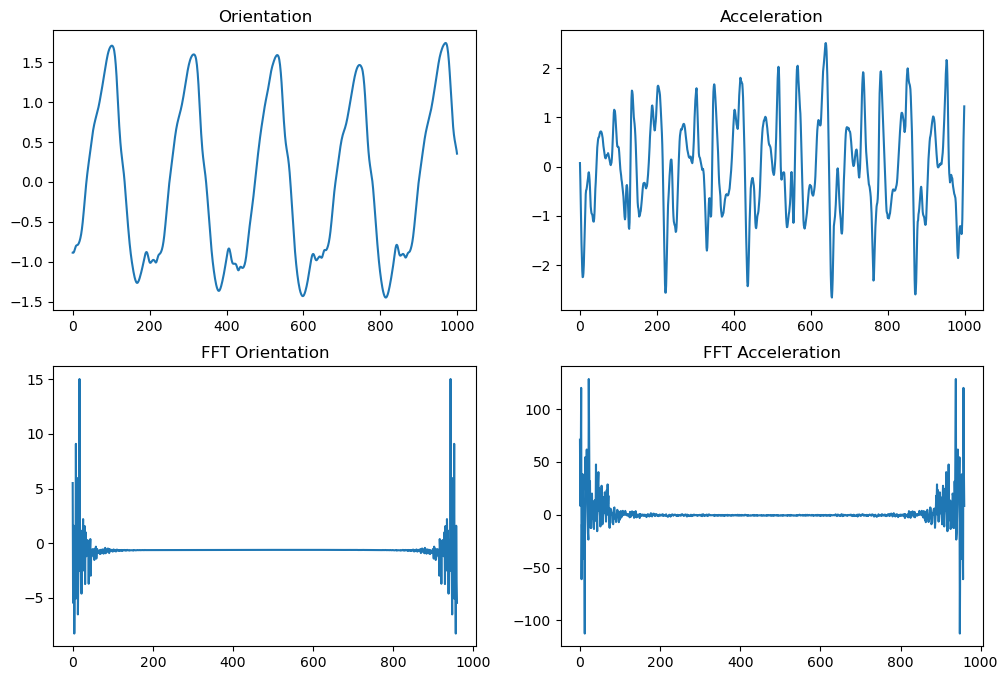

In [119]:
#Plotting the signal and FFT for the a specific time bin
time_bin_number = 15
fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs[0, 0].plot(data_signal[1,time_bin_number,:])
axs[0, 0].set_title('Orientation')
axs[0, 1].plot(data_signal[4,time_bin_number,:])
axs[0, 1].set_title('Acceleration')
axs[1, 0].plot(data_fft[1,time_bin_number,20:-20])
axs[1, 0].set_title('FFT Orientation')
axs[1, 1].plot(data_fft[4,time_bin_number,20:-20])
axs[1, 1].set_title('FFT Acceleration')

Next up is to apply a clustering algorithm. 